
# The $k$-Nearest Neighbor Classification Algorithm

    Notebook version: 2.2 (Oct 25, 2020)

    Author: Jesús Cid Sueiro (jcid@tsc.uc3m.es)
            Jerónimo Arenas García (jarenas@tsc.uc3m.es)
            
    Changes: v.1.0 - First version
             v.1.1 - Function loadDataset updated to work with any number of dimensions
             v.2.0 - Compatible with Python 3 (backcompatible with Python 2.7)
                     Added solution to Exercise 3
             v.2.1 - Minor corrections regarding notation
             v.2.2 - Adaptation for slides conversion
             

In [1]:
# To visualize plots in the notebook
%matplotlib inline 

# Import some libraries that will be necessary for working with data and displaying plots
import csv     # To read csv files
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy import spatial
from sklearn import neighbors, datasets

## 1. The binary classification problem.

In a binary classification problem, we are given an observation vector ${\bf x}\in \mathbb{R}^N$ which is known to belong to one and only one *category* or *class*, $y$, in the set ${\mathcal Y} = \{0, 1\}$. The goal of a classifier system is to predict the value of $y$ based on ${\bf x}$.

To design the classifier, we are given a collection of labelled observations ${\mathcal D} = \{({\bf x}_k, y_k)\}_{k=0}^{K-1}$ where, for each observation ${\bf x}_k$, the value of its true category, $y_k$, is known. All samples are outcomes of an unknown distribution $p_{{\bf X},Y}({\bf x}, y)$.

## 2. The Iris dataset

(Iris dataset presentation is based on this <a href=http://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/> Tutorial </a> by <a href=http://machinelearningmastery.com/about/> Jason Brownlee</a>) 

To illustrate the algorithms, we will consider the <a href = http://archive.ics.uci.edu/ml/datasets/Iris> Iris dataset </a>, taken from the <a href=http://archive.ics.uci.edu/ml/> UCI Machine Learning repository </a>. Quoted from the dataset description:

> This is perhaps the best known database to be found in the pattern recognition literature. The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant. [...] One class is linearly separable from the other 2; the latter are NOT linearly separable from each other. 

The *class* is the species, which is one of *setosa*, *versicolor* or *virginica*. Each instance contains 4 measurements of given flowers: sepal length, sepal width, petal length and petal width, all in centimeters. 


In [2]:
# Taken from Jason Brownlee notebook.
with open('datasets/iris.data', 'r') as csvfile:
	lines = csv.reader(csvfile)
	for row in lines:
		print(', '.join(row))

5.1, 3.5, 1.4, 0.2, Iris-setosa
4.9, 3.0, 1.4, 0.2, Iris-setosa
4.7, 3.2, 1.3, 0.2, Iris-setosa
4.6, 3.1, 1.5, 0.2, Iris-setosa
5.0, 3.6, 1.4, 0.2, Iris-setosa
5.4, 3.9, 1.7, 0.4, Iris-setosa
4.6, 3.4, 1.4, 0.3, Iris-setosa
5.0, 3.4, 1.5, 0.2, Iris-setosa
4.4, 2.9, 1.4, 0.2, Iris-setosa
4.9, 3.1, 1.5, 0.1, Iris-setosa
5.4, 3.7, 1.5, 0.2, Iris-setosa
4.8, 3.4, 1.6, 0.2, Iris-setosa
4.8, 3.0, 1.4, 0.1, Iris-setosa
4.3, 3.0, 1.1, 0.1, Iris-setosa
5.8, 4.0, 1.2, 0.2, Iris-setosa
5.7, 4.4, 1.5, 0.4, Iris-setosa
5.4, 3.9, 1.3, 0.4, Iris-setosa
5.1, 3.5, 1.4, 0.3, Iris-setosa
5.7, 3.8, 1.7, 0.3, Iris-setosa
5.1, 3.8, 1.5, 0.3, Iris-setosa
5.4, 3.4, 1.7, 0.2, Iris-setosa
5.1, 3.7, 1.5, 0.4, Iris-setosa
4.6, 3.6, 1.0, 0.2, Iris-setosa
5.1, 3.3, 1.7, 0.5, Iris-setosa
4.8, 3.4, 1.9, 0.2, Iris-setosa
5.0, 3.0, 1.6, 0.2, Iris-setosa
5.0, 3.4, 1.6, 0.4, Iris-setosa
5.2, 3.5, 1.5, 0.2, Iris-setosa
5.2, 3.4, 1.4, 0.2, Iris-setosa
4.7, 3.2, 1.6, 0.2, Iris-setosa
4.8, 3.1, 1.6, 0.2, Iris-setosa
5.4, 3.4

### 2.1. Train/test split

Next, we will split the data into two sets:

* **Training set**, that will be used to learn the classification model
* **Test set**, that will be used to evaluate the classification performance

The data partition must be **random**, in such a way that the statistical distribution of both datasets is the same.

The code fragment below defines a function `loadDataset` that loads the data in a CSV with the provided filename, converts the flower measures (that were loaded as strings) into numbers and, finally, it splits the data into a training and test sets.

In [3]:
# Adapted from a notebook by Jason Brownlee
def loadDataset(filename, split):
    xTrain = []
    cTrain = []
    xTest = []
    cTest = []

    with open(filename, 'r') as csvfile:
        lines = csv.reader(csvfile)
        dataset = list(lines)
    for i in range(len(dataset)-1):
        for y in range(4):
            dataset[i][y] = float(dataset[i][y])
        item = dataset[i]
        if random.random() < split:
            xTrain.append(item[0:-1])
            cTrain.append(item[-1])
        else:
            xTest.append(item[0:-1])
            cTest.append(item[-1])
    return xTrain, cTrain, xTest, cTest

We can use this function to get a data split. An expected ratio of 67/33 samples for train/test will be used. However, note that, because of the way samples are assigned to the train or test datasets, the exact number of samples in each partition will differ if you run the code several times.

In [4]:
xTrain_all, cTrain_all, xTest_all, cTest_all = loadDataset('datasets/iris.data', 0.67)
nTrain_all = len(xTrain_all)
nTest_all = len(xTest_all)
print('Train:', nTrain_all)
print('Test:', nTest_all)

Train: 92
Test: 58


### 2.2. Versicolor vs Virginica

In the following, we will design a classifier to separate classes "Versicolor" and "Virginica" using $x_0$ and $x_1$ only. To do so, we build a training set with samples from these categories, and a bynary label $y^{(k)} = 1$ for samples in class "Virginica", and $0$ for "Versicolor" data.

In [5]:
# Select two classes
c0 = 'Iris-versicolor' 
c1 = 'Iris-virginica'

# Select two coordinates
ind = [0, 1]

# Take training test
X_tr = np.array([[xTrain_all[n][i] for i in ind] for n in range(nTrain_all) 
                  if cTrain_all[n]==c0 or cTrain_all[n]==c1])
C_tr = [c for c in cTrain_all if c==c0 or c==c1]
Y_tr = np.array([int(c==c1) for c in C_tr])
n_tr = len(X_tr)

# Take test set
X_tst = np.array([[xTest_all[n][i] for i in ind] for n in range(nTest_all) 
                 if cTest_all[n]==c0 or cTest_all[n]==c1])
C_tst = [c for c in cTest_all if c==c0 or c==c1]
Y_tst = np.array([int(c==c1) for c in C_tst])
n_tst = len(X_tst)

# Separate components of x into different arrays (just for the plots)
x0c0 = [X_tr[n][0] for n in range(n_tr) if Y_tr[n]==0]
x1c0 = [X_tr[n][1] for n in range(n_tr) if Y_tr[n]==0]
x0c1 = [X_tr[n][0] for n in range(n_tr) if Y_tr[n]==1]
x1c1 = [X_tr[n][1] for n in range(n_tr) if Y_tr[n]==1]

A scatter plot is useful to get some insights on the difficulty of the classification problem

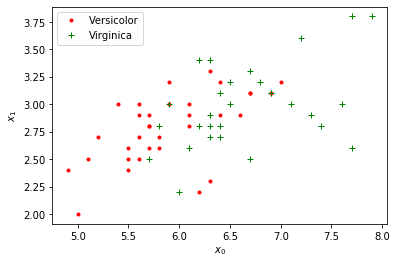

In [6]:
# Scatterplot.
labels = {'Iris-setosa': 'Setosa', 
          'Iris-versicolor': 'Versicolor',
          'Iris-virginica': 'Virginica'}
plt.plot(x0c0, x1c0,'r.', label=labels[c0])
plt.plot(x0c1, x1c1,'g+', label=labels[c1])
plt.xlabel('$x_' + str(ind[0]) + '$')
plt.ylabel('$x_' + str(ind[1]) + '$')
plt.legend(loc='best')
plt.show()

## 3. Baseline Classifier: Maximum A Priori.

For the selected data set, we have two clases and a dataset with the following class proportions:

In [7]:
print(f'Class 0 {c0}: {n_tr - sum(Y_tr)} samples')
print(f'Class 1 ({c1}): {sum(Y_tr)} samples')

Class 0 Iris-versicolor: 33 samples
Class 1 (Iris-virginica): 29 samples


The maximum a priori classifier assigns any sample ${\bf x}$ to the most frequent class in the training set. Therefore, the class prediction $y$ for any sample ${\bf x}$ is

In [8]:
y = int(2*sum(Y_tr) > n_tr)
print(f'y = {y} ({c1 if y==1 else c0})')

y = 0 (Iris-versicolor)


The error rate for this baseline classifier is:

In [9]:
# Training and test error arrays
E_tr = (Y_tr != y)
E_tst = (Y_tst != y)

# Error rates
pe_tr = float(sum(E_tr)) / n_tr
pe_tst = float(sum(E_tst)) / n_tst
print('Pe(train):', pe_tr)
print('Pe(test):', pe_tst)

Pe(train): 0.46774193548387094
Pe(test): 0.5526315789473685


The error rate of the baseline classifier is a simple benchmark for classification. Since the maximum a priori decision is independent on the observation, ${\bf x}$, any classifier based on ${\bf x}$ should have a better (or, at least, not worse) performance than the baseline classifier.

## 4. The Nearest-Neighbour Classifier (1-NN).


The 1-NN classifier assigns any instance ${\bf x}$ to the category of the nearest neighbor in the training set.
$$
d = f({\bf x}) = y_n, {\rm~where} \\
n = \arg \min_k \|{\bf x}-{\bf x}_k\|
$$
In case of ties (i.e. if there is more than one instance at minimum distance) the class of one of them, taken arbitrarily, is assigned to ${\bf x}$.

In [10]:
def nn_classifier(X1, Y1, X2):
    """ Compute the 1-NN classification for the observations contained in
        the rows of X2, for the training set given by the rows in X1 and the
        class labels contained in Y1.
    """
    if X1.ndim == 1:
        X1 = np.asmatrix(X1).T
    if X2.ndim == 1:
        X2 = np.asmatrix(X2).T
    distances = spatial.distance.cdist(X1,X2,'euclidean')
    neighbors = np.argsort(distances, axis=0, kind='quicksort', order=None)
    closest = neighbors[0,:]
    y_values = np.zeros([X2.shape[0],1])
    for idx in range(X2.shape[0]):
        y_values[idx] = Y1[closest[idx]]
        
    return y_values

Let us apply the 1-NN classifier to the given dataset. First, we will show the decision regions of the classifier. To do so, we compute the classifier output for all points in a rectangular grid from the sample space.

In [11]:
# Create a regtangular grid.
n_points = 200
x_min, x_max = X_tr[:, 0].min(), X_tr[:, 0].max() 
y_min, y_max = X_tr[:, 1].min(), X_tr[:, 1].max()
dx = x_max - x_min
dy = y_max - y_min
h = dy / n_points
xx, yy = np.meshgrid(np.arange(x_min - 0.1 * dx, x_max + 0.1 * dx, h),
                     np.arange(y_min - 0.1 * dx, y_max + 0.1 * dy, h))
X_grid = np.array([xx.ravel(), yy.ravel()]).T

# Compute the classifier output for all samples in the grid.
Z = nn_classifier(X_tr, Y_tr, X_grid)

Now we plot the results

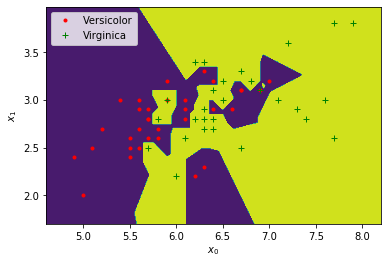

In [12]:
# Put the result into a color plot
plt.plot(x0c0, x1c0,'r.', label=labels[c0])
plt.plot(x0c1, x1c1,'g+', label=labels[c1])
plt.xlabel('$x_' + str(ind[0]) + '$')
plt.ylabel('$x_' + str(ind[1]) + '$')
plt.legend(loc='best')

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.show()

We can observe that the decision boudary of the 1-NN classifier is rather intricate, and it may contain small *islands* covering one or few samples from one class. Actually, the extension of these small regions usually reduces as we have more training samples, though the number of them may increase.

Now we compute the error rates over the training and test sets.

In [13]:
# Training errors
Z_tr = nn_classifier(X_tr, Y_tr, X_tr)
E_tr = Z_tr.flatten()!=Y_tr

# Test errors
Z_tst = nn_classifier(X_tr, Y_tr, X_tst)
E_tst = Z_tst.flatten()!=Y_tst

# Error rates
pe_tr = float(sum(E_tr)) / n_tr
pe_tst = float(sum(E_tst)) / n_tst
print('Pe(train):', pe_tr)
print('Pe(test):', pe_tst)

Pe(train): 0.04838709677419355
Pe(test): 0.47368421052631576


The training and test error rates of the 1-NN may be significantly different. In fact, the training error may go down to zero if samples do not overlap. In the selected problem, this is not the case, because samples from different classes coincide at the same point, causing some classification errors.

### 4.1. Consistency of the 1-NN classifier

Despite the 1-NN usually reduces the error rate with respect to the baseline classifier, the number of errors may be too large. Errors may be attributed to diferent causes:

   1. The class distributions are overlapped, because the selected features have no complete information for discriminating between the classes: this would imply that, even the best possible classifier would be prone to errors.
   2. The training sample is small, and it is not enough to obtaing a good estimate of the optimal classifiers.
   3. The classifier has intrinsic limitations: even though we had an infinite number of samples, the classifier performance does not approach the optimal classifiers.

In general, a classifier is said to be consistent if it makes nearly optimal decisions as the number of training samples increases. Actually, it can be shown that this is the case of the 1-NN classifier if the classification problem is separable, i.e. if there exist a decision boundary with zero error probability. Unfortunately, in a non-separable case, the 1-NN classifier is not consistent. It can be shown that the error rate of the 1-NN classifier converges to an error rate which is not worse than twice the minimum attainable error rate (Bayes error rate) as the number of training samples goes to infinity.

**Exercise 1**: In this exercise we test the non-consistency of the 1-NN classifier for overlapping distributions. Generate an artificial dataset for classification as follows:

- Generate $N$ binary labels at random with values '0' and '1'. Store them in vector ${\bf y}$
- For every label $y_k$ in ${\bf y}$:
    - If the label is 0, take sample $x_k$ at random from a uniform distribution $U(0,2)$.
    - If the label is 1, take sample $x_k$ at random from a uniform distribution $U(1,5)$.

Take $N=1000$ for the test set. This is a large sample to get accurate error rate estimates. Also, take $N=10$, $20$, $40$, $80$,... for the training set. Compute the 1-NN classifier, and observe the test error rate as a function of $N$. 

Now, compute the test error rate of the classifier making decision $1$ if $x_k>1.5$, and $0$ otherwise. 


In [14]:
# <SOL>
from sklearn.neighbors import KNeighborsClassifier

Ntest = 10000
Ntr = [10, 20, 40, 80, 200, 1000]
nruns = 100

xtest = []
ytest = []
for k in range(Ntest):
    if k<Ntest/2:
        ytest.append(0)
        xtest.append([2*np.random.random()])
    else:
        ytest.append(1)
        xtest.append([1+4*np.random.random()])
#print(np.mean(np.array(ytest)))
#print(xtest)

Etest = np.zeros((len(Ntr),))
for k in range(nruns):
    for kk,Ntrain in enumerate(Ntr):
        xtrain = []
        ytrain = []
        for k in range(Ntrain):
            if k < Ntrain / 2:
                ytrain.append(0)
                xtrain.append([2*np.random.random()])
            else:
                ytrain.append(1)
                xtrain.append([1+4*np.random.random()])

        # Train the classifier and get predictions for ytest
        neigh = KNeighborsClassifier(n_neighbors=1)
        ytest_pred = neigh.fit(xtrain,ytrain).predict(xtest)
        error_rate = np.mean(np.array(ytest)!=ytest_pred)
        
        Etest[kk] += error_rate/nruns

print(Etest)
# </SOL>

[0.180574 0.177778 0.168359 0.16686  0.163171 0.161425]


## 5. $k$-NN classifier

A simple extension of the 1-NN classifier is the $k$-NN classifier, which, for any input sample ${\bf x}$, computes the $k$ closest neighbors in the training set, and takes the majority class in the subset. To avoid ties, in the binary classification case $k$ is usually taken as an odd number.

The following method implements the $k$-NN classifiers.

In [15]:
def knn_classifier(X1,Y1,X2,k):
    """ Compute the k-NN classification for the observations contained in
        the rows of X2, for the training set given by the rows in X1 and the
        components of S1. k is the number of neighbours.
    """
    if X1.ndim == 1:
        X1 = np.asmatrix(X1).T
    if X2.ndim == 1:
        X2 = np.asmatrix(X2).T
    distances = spatial.distance.cdist(X1,X2,'euclidean')
    neighbors = np.argsort(distances, axis=0, kind='quicksort', order=None)
    closest = neighbors[range(k),:]
    
    y_values = np.zeros([X2.shape[0],1])
    for idx in range(X2.shape[0]):
        y_values[idx] = np.median(Y1[closest[:,idx]])
        
    return y_values

Now, we can plot the decision boundaries for different values of $k$

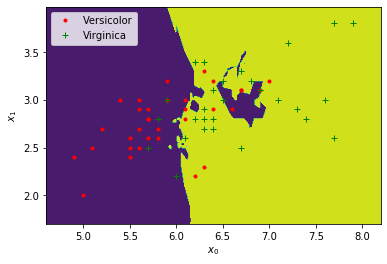

In [16]:
k = 7

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = knn_classifier(X_tr, Y_tr, X_grid, k)

# Put the result into a color plot
plt.plot(x0c0, x1c0,'r.', label=labels[c0])
plt.plot(x0c1, x1c1,'g+', label=labels[c1])
plt.xlabel('$x_' + str(ind[0]) + '$')
plt.ylabel('$x_' + str(ind[1]) + '$')
plt.legend(loc='best')

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.show()

### 5.1. Influence of $k$

We can analyze the influence of parameter $k$ by observing both traning and test errors.

In [17]:
# Plot training and test error as a function of parameter k.
pe_tr = []
pe_tst = []
k_list = [2*n+1 for n in range(int(np.floor(n_tr/2)))]

for k in k_list:
    # Training errors
    Z_tr = knn_classifier(X_tr, Y_tr, X_tr, k)
    E_tr = Z_tr.flatten()!=Y_tr

    # Test errors
    Z_tst = knn_classifier(X_tr, Y_tr, X_tst, k)
    E_tst = Z_tst.flatten()!=Y_tst

    # Error rates
    pe_tr.append(float(sum(E_tr)) / n_tr)
    pe_tst.append(float(sum(E_tst)) / n_tst)

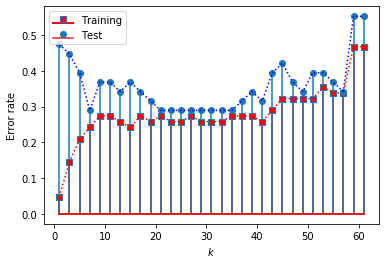

In [18]:
# Put the result into a color plot
markerline, stemlines, baseline = plt.stem(k_list, pe_tr, 'r', markerfmt='s', label='Training',
                                           use_line_collection=True)
plt.plot(k_list, pe_tr,'r:')
plt.setp(markerline, 'markerfacecolor', 'r', )
plt.setp(baseline, 'color','r', 'linewidth', 2)
markerline, stemlines, baseline = plt.stem(k_list, pe_tst, label='Test', use_line_collection=True)
plt.plot(k_list, pe_tst,'b:')
plt.xlabel('$k$')
plt.ylabel('Error rate')
plt.legend(loc='best')
plt.show()

**Exercise 2**: Observe the train and test error for large $k$. Could you relate the error rate of the baseline classifier with that to the $k$-NN for certain value of $k$? 

The figure above suggests that the optimal value of $k$ is

In [19]:
i = np.argmin(pe_tst)
k_opt = k_list[i]
print('k_opt:', k_opt)

k_opt: 7


However, using the test set to select the optimal value of the hyperparameter $k$ is not allowed. Instead, we should recur to cross validation.

### 5.2 Hyperparameter selection via cross-validation

An inconvenient of the application of the $k$-NN method is that the selection of $k$ influences the final error of the algorithm. In the previous experiments, we noticed that the location of the minimum is not necessarily the same from the perspective of the test and training data. Ideally, we would like that the designed classification model works as well as possible on future unlabeled patterns that are not available during the training phase. This property is known as **generalization**. 

Fitting the training data is only pursued in the hope that we are also indirectly obtaining a model that generalizes well. In order to achieve this goal, there are some strategies that try to guarantee a correct generalization of the model. One of such approaches is known as <b>cross-validation</b>.

Since using the test labels during the training phase is not allowed (they should be kept aside to simultate the future application of the classification model on unseen patterns), we need to figure out some way to improve our estimation of the hyperparameter that requires only training data. Cross-validation allows us to do so by following the following steps:

   1. **Split the training data** into several (generally non-overlapping) subsets. If we use $M$ subsets, the method is referred to as $M$-fold cross-validation. If we consider each pattern a different subset, the method is usually referred to as leave-one-out (LOO) cross-validation.
   2. **Train** of the system $M$ times. For each run, use a different partition as a *validation* set, and use the restating partitions as the training set. **Evaluate** the performance for different choices of the hyperparameter (i.e., for different values of $k$ for the $k$-NN method).
   3. **Average the validation error** over all partitions, and pick the hyperparameter that provided the minimum validation error.
   4. **Rerun** the algorithm using all the training data, keeping the value of the parameter that came out of the cross-validation process.

In [20]:
## k-nn with M-fold cross validation

# Obtain the indices for the different folds
n_tr = X_tr.shape[0]
M = n_tr
permutation = np.random.permutation(n_tr)
# Initialize sets of indices
set_indices = {n: [] for n in range(M)}

# Distribute data amont M partitions
n = 0
for pos in range(n_tr):
    set_indices[n].append(permutation[pos])
    n = (n+1) % M

# Now, we run the cross-validation process using the k-nn method
k_max = 30
k_list = [2*j+1 for j in range(int(k_max))]

# Obtain the validation errors
pe_val = 0
for n in range(M):
    i_val = set_indices[n]
    i_tr = []
    for kk in range(M):
        if not n==kk:
            i_tr += set_indices[kk]
    
    pe_val_iter = []
    for k in k_list:
        y_tr_iter = knn_classifier(X_tr[i_tr], Y_tr[i_tr], X_tr[i_val], k)
        pe_val_iter.append(np.mean(Y_tr[i_val] != y_tr_iter))

    pe_val = pe_val + np.asarray(pe_val_iter).T

pe_val = pe_val / M

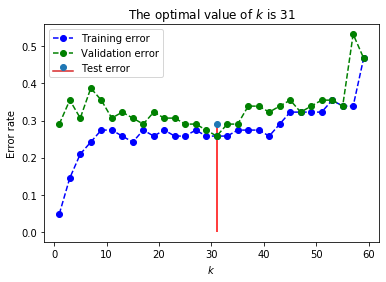

In [21]:
# We compute now the train and test errors curves
pe_tr = [np.mean(Y_tr != knn_classifier(X_tr, Y_tr, X_tr, k).T) for k in k_list]
k_opt = k_list[np.argmin(pe_val)]
pe_tst = np.mean(Y_tst != knn_classifier(X_tr, Y_tr, X_tst, k_opt).T)

plt.plot(k_list, pe_tr,'b--o',label='Training error')
plt.plot(k_list, pe_val.T,'g--o',label='Validation error')
plt.stem([k_opt], [pe_tst],'r-o',label='Test error', use_line_collection=True)
plt.legend(loc='best')
plt.title('The optimal value of $k$ is ' + str(k_opt))
plt.xlabel('$k$')
plt.ylabel('Error rate')
plt.show()

## 6. Scikit-learn implementation

In practice, most well-known machine learning methods are implemented and available for python. Probably, the most complete library for machine learning is <a href=http://scikit-learn.org/stable/>Scikit-learn</a>. The following piece of code uses the method

    KNeighborsClassifier
    
available in Scikit-learn, to compute the $k$-NN classifier using the four components of the observations in the original dataset. This routine allows us to classify a particular point using a weighted average of the targets of the neighbors:

   To classify point ${\bf x}$:
   
   - Find $k$ closest points to ${\bf x}$ in the training set
   - Average the corresponding targets, weighting each value according to the distance of each point to ${\bf x}$, so that closer points have a larger influence in the estimation.


In [22]:
k = 5
# import some data to play with
iris = datasets.load_iris()

# Take training test
X_tr = np.array([xTrain_all[n] for n in range(nTrain_all) 
                 if cTrain_all[n]==c0 or cTrain_all[n]==c1])
C_tr = [c for c in cTrain_all if c==c0 or c==c1]
Y_tr = np.array([int(c==c1) for c in C_tr])
n_tr = len(X_tr)

# Take test set
X_tst = np.array([xTest_all[n] for n in range(nTest_all) 
                 if cTest_all[n]==c0 or cTest_all[n]==c1])
C_tst = [c for c in cTest_all if c==c0 or c==c1]
Y_tst = np.array([int(c==c1) for c in C_tst])
n_tst = len(X_tst)

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(k, weights=weights)
    clf.fit(X_tr, Y_tr)
    Z = clf.predict(X_tst)
    pe_tst = np.mean(Y_tst != Z)
    print(f'Test error rate with {weights} weights = {pe_tst}')

Test error rate with uniform weights = 0.10526315789473684
Test error rate with distance weights = 0.10526315789473684


<a href = http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html> Here</a> you can find an example of the application of `KNeighborsClassifier` to the complete 3-class Iris flower classification problem.

## 7. $k$-NN Classification and Probability Estimation.

If a sample ${\bf x}$ has $m$ neighbors from class 1 and $k-m$ neighbors from class $0$, we can estimate the **posterior probability** that an observation ${\bf x}$ belongs to class 1 as
$$
\hat P\{y=1|x\} = \frac{m}{k}
$$
Therefore, besides computing a decision about the class of the data, we can modify the $k$-NN algorithm to obtain posterior probability estimates.

Note that the above equation is equivalent to
$$
\hat P\{y=1|x\} = \frac{\sum_{n \in {\mathcal N}({\bf x})} y^{(n)}}{k}
$$
where ${\mathcal N}({\bf x})$ is the set of indices for the samples in the neighborhood of $\bf x$.

In other words, $\hat P\{y=1|x\}$ is the *average* of the neighbor labels. This is actually what the $k$-NN regression algorithm does. Thus, we can estimate the posterior using the `sklearn` regression methods from `KNeighborsRegressor`.


**Exercise 3**: Plot a $k$-NN posterior probability map for the Iris flower data, for $k=15$.

In [23]:
# Select two classes
c0 = 'Iris-versicolor' 
c1 = 'Iris-virginica'
# Select two coordinates
coords = [0, 1]

# Take the selected coordinates only
X_tr = np.array(xTrain_all)[:, coords]
X_tst = np.array(xTest_all)[:, coords]

# Take training test
ind = [i for i, c in enumerate(cTrain_all) if c==c0 or c==c1]
X_tr = X_tr[ind, :]
C_tr = np.array(cTrain_all)[ind]
Y_tr = (C_tr == c1)

# Take test set
ind = [i for i, c in enumerate(cTest_all) if c==c0 or c==c1]
X_tst = X_tst[ind, :]
C_tst = np.array(cTest_all)[ind]
Y_tst = (C_tst == c1)

In [24]:
#<SOL>
from sklearn import neighbors

k = 15
neigh = neighbors.KNeighborsRegressor(n_neighbors=k)
Z = neigh.fit(X_tr, Y_tr).predict(X_grid)

# Separate components of x into different arrays (just for the plots)
x0c0 = [X_tr[n][0] for n, y in enumerate(Y_tr) if y==0]
x1c0 = [X_tr[n][1] for n, y in enumerate(Y_tr) if y==0]
x0c1 = [X_tr[n][0] for n, y in enumerate(Y_tr) if y==1]
x1c1 = [X_tr[n][1] for n, y in enumerate(Y_tr) if y==1]
#</SOL>

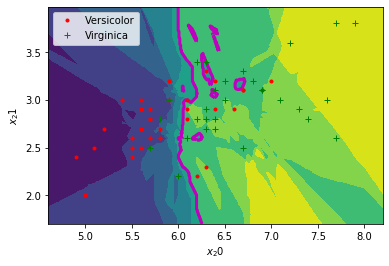

In [25]:
#<SOL>
# Put the result into a color plot
plt.plot(x0c0, x1c0,'r.', label=labels[c0])
plt.plot(x0c1, x1c1,'g+', label=labels[c1])
plt.xlabel('$x_' + str(ind[0]) + '$')
plt.ylabel('$x_' + str(ind[1]) + '$')
plt.legend(loc='best')

Z = Z.reshape(xx.shape)
CS = plt.contourf(xx, yy, Z)
CS2 = plt.contour(CS, levels=[0.5], colors='m', linewidths=(3,))
plt.show()
#</SOL>